# Phase 4: Depth Alignment (Clean Version)

Align volumes in depth (Y-axis) using retinal surface matching.

## Workflow:
1. Load XY registration results and surface data
2. Apply XY translation to surfaces
3. Compare two depth alignment methods
4. Select best method and visualize
5. Save complete 3D registration

## Setup and Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from scipy.ndimage import shift

data_dir = Path('data')
print("✓ Imports complete")

✓ Imports complete


## Step 1: Load Data

In [2]:
# Load XY registration and surfaces
xy_params = np.load(data_dir / 'xy_registration_params.npy', allow_pickle=True).item()
translation_xy = np.array(xy_params['translation_yx'])

surface_v0 = np.load(data_dir / 'surface_peaks_volume0.npy')
surface_v1 = np.load(data_dir / 'surface_peaks_volume1.npy')

print(f"XY Translation: ({translation_xy[0]:.2f}, {translation_xy[1]:.2f}) pixels")
print(f"Surface shapes: {surface_v0.shape}")
print(f"Surface ranges:")
print(f"  Volume 0: [{surface_v0.min():.0f}, {surface_v0.max():.0f}]")
print(f"  Volume 1: [{surface_v1.min():.0f}, {surface_v1.max():.0f}]")

XY Translation: (0.00, 0.00) pixels
Surface shapes: (1536, 360)
Surface ranges:
  Volume 0: [286, 620]
  Volume 1: [193, 811]


## Step 2: Apply XY Translation to Surfaces

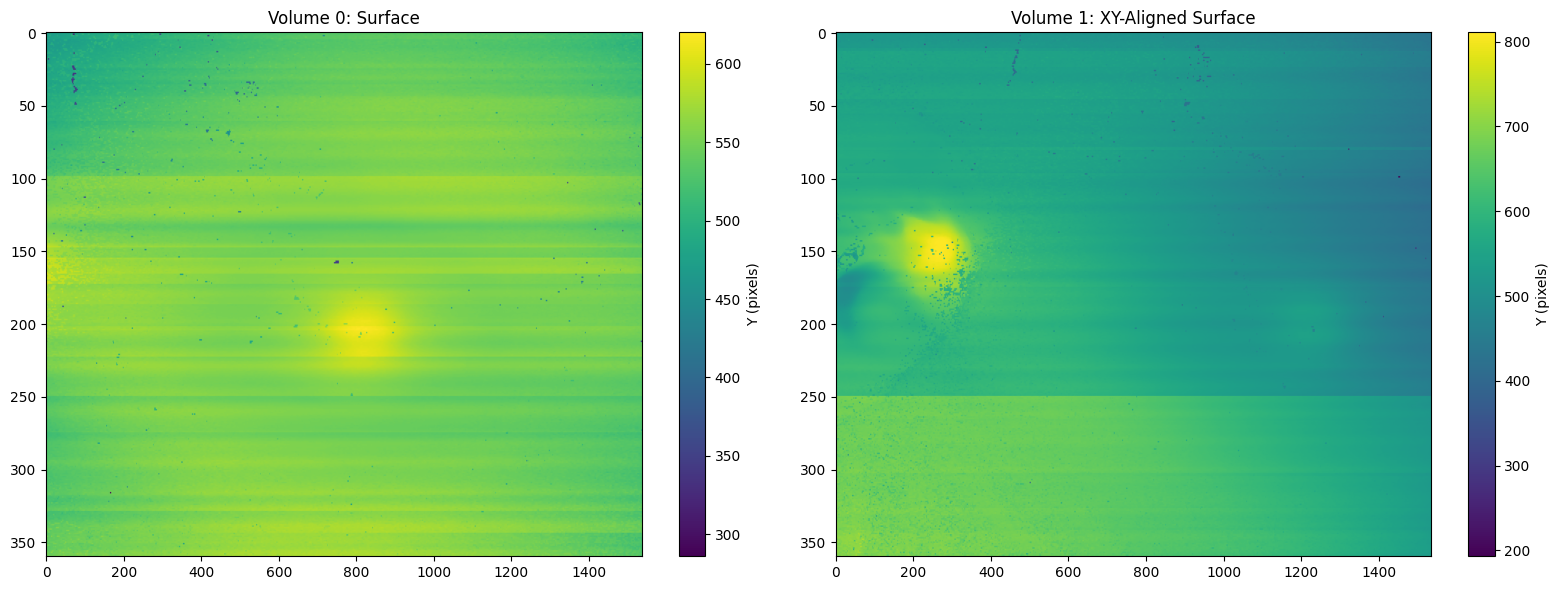


After XY alignment: mean difference = 58.33 pixels


In [3]:
# Apply XY shift to volume 1 surface
dy, dx = translation_xy
surface_v1_xy = shift(surface_v1, shift=(dx, dy), order=1, mode='constant', cval=np.nan)

# Visualize
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

im0 = axes[0].imshow(surface_v0.T, aspect='auto', cmap='viridis')
axes[0].set_title('Volume 0: Surface')
plt.colorbar(im0, ax=axes[0], label='Y (pixels)')

im1 = axes[1].imshow(surface_v1_xy.T, aspect='auto', cmap='viridis')
axes[1].set_title('Volume 1: XY-Aligned Surface')
plt.colorbar(im1, ax=axes[1], label='Y (pixels)')

plt.tight_layout()
plt.show()

diff = np.abs(surface_v0 - surface_v1_xy)
print(f"\nAfter XY alignment: mean difference = {np.nanmean(diff):.2f} pixels")

## Step 3: Calculate Depth Offset (Two Methods)

In [4]:
def method_median(ref, mov, overlap_region=None):
    """Method A: Robust median offset."""
    if overlap_region:
        x0, x1, z0, z1 = overlap_region
        ref = ref[x0:x1, z0:z1]
        mov = mov[x0:x1, z0:z1]
    diff = ref - mov
    offset = np.nanmedian(diff)
    std = np.nanstd(diff)
    confidence = 1.0 / (1.0 + std / 10.0)
    return offset, confidence

def method_correlation(ref, mov, overlap_region=None, max_shift=100):
    """Method B: Exhaustive search for best alignment."""
    if overlap_region:
        x0, x1, z0, z1 = overlap_region
        ref = ref[x0:x1, z0:z1]
        mov = mov[x0:x1, z0:z1]
    
    scores = []
    offsets = range(-max_shift, max_shift + 1)
    for offset in offsets:
        diff = np.abs(ref - (mov + offset))
        scores.append(-np.nanmean(diff))
    
    scores = np.array(scores)
    best_idx = np.argmax(scores)
    best_offset = offsets[best_idx]
    confidence = (scores[best_idx] - scores.min()) / (scores.max() - scores.min() + 1e-8)
    return best_offset, confidence

# Define overlap region (12.5% on each side)
W, D = surface_v0.shape
overlap = int(W * 0.125)
region = (W - overlap, W, 0, D)

print("Method A: Median Offset")
offset_a, conf_a = method_median(surface_v0, surface_v1_xy, region)
print(f"  Offset: {offset_a:.2f} px, Confidence: {conf_a:.2%}")

print("\nMethod B: Correlation")
offset_b, conf_b = method_correlation(surface_v0, surface_v1_xy, region)
print(f"  Offset: {offset_b:.2f} px, Confidence: {conf_b:.2%}")

# Select best
if conf_b > conf_a:
    offset_final = offset_b
    conf_final = conf_b
    method = "Correlation (Method B)"
else:
    offset_final = offset_a
    conf_final = conf_a
    method = "Median (Method A)"

print(f"\n✓ Selected: {method}")
print(f"  Final offset: {offset_final:.2f} pixels")
print(f"  Confidence: {conf_final:.2%}")

Method A: Median Offset
  Offset: 75.00 px, Confidence: 16.73%

Method B: Correlation
  Offset: 75.00 px, Confidence: 100.00%

✓ Selected: Correlation (Method B)
  Final offset: 75.00 pixels
  Confidence: 100.00%


## Step 4: Apply and Visualize Final Alignment

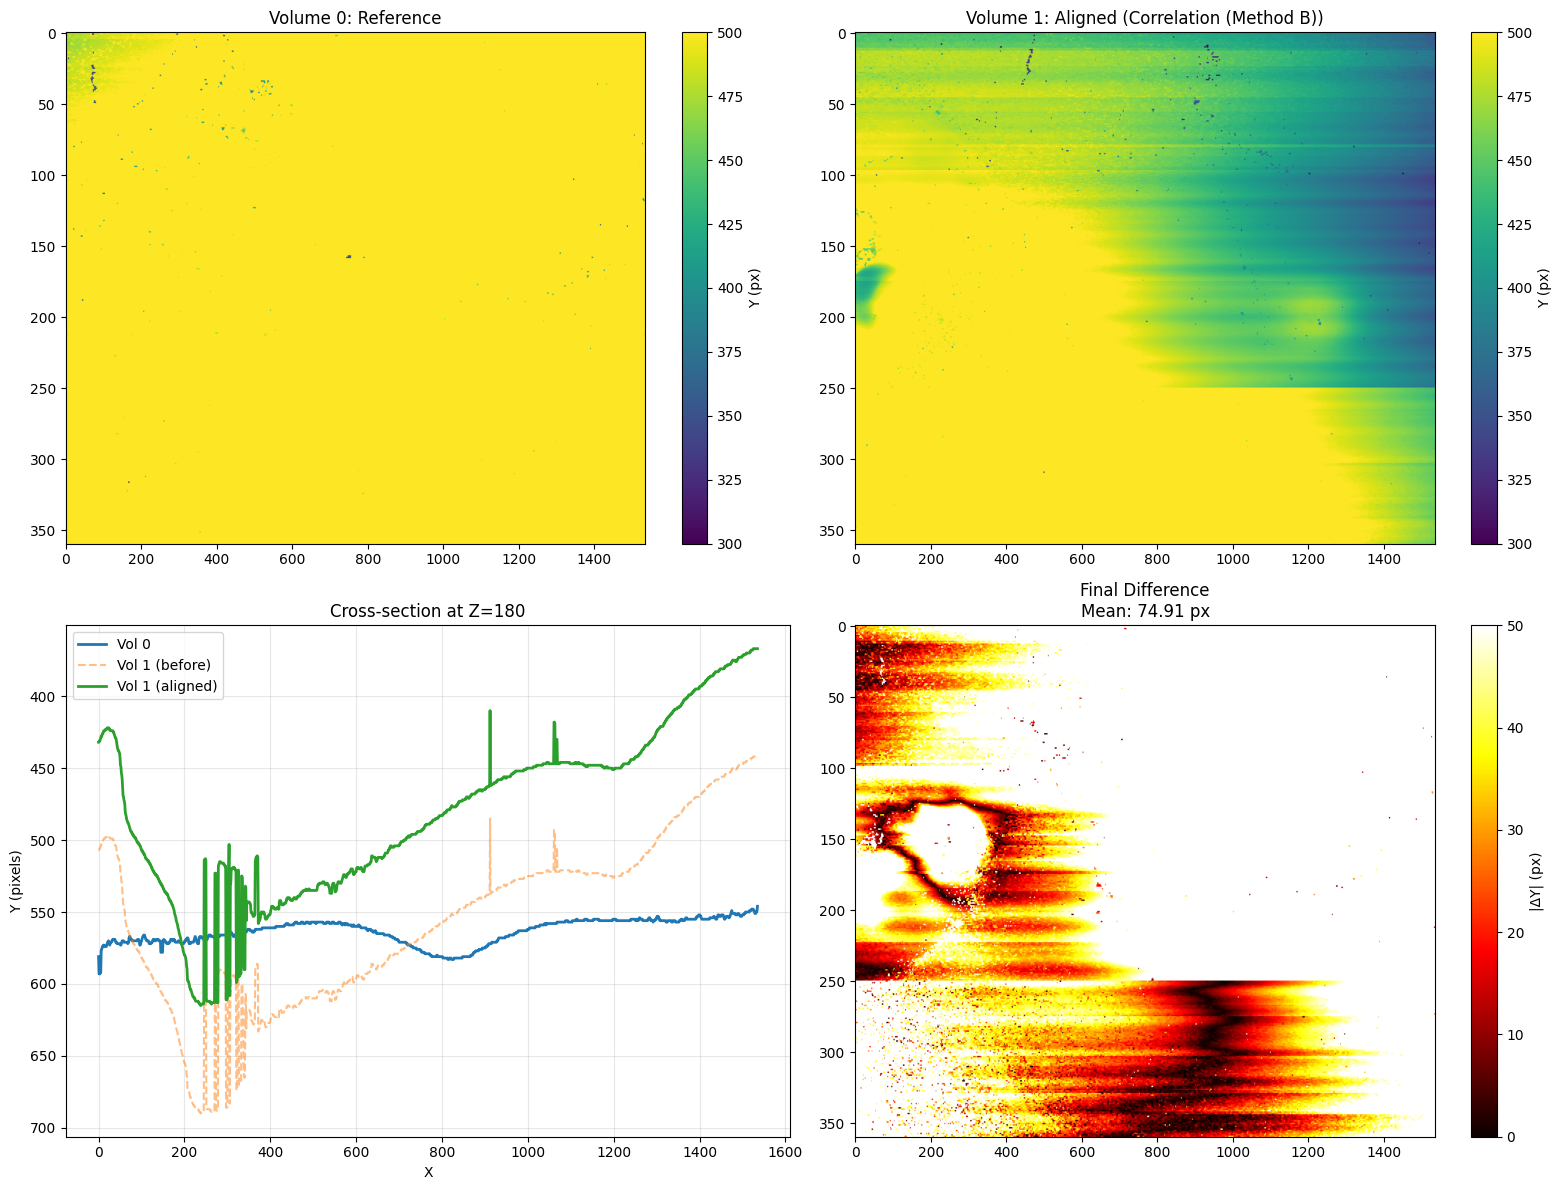


Alignment Quality:
  Before depth alignment: 58.33 px
  After depth alignment: 74.91 px
  Improvement: -28.4%


In [5]:
# Apply depth offset
surface_v1_final = surface_v1_xy - offset_final

# Visualize
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Surface maps
im0 = axes[0, 0].imshow(surface_v0.T, aspect='auto', cmap='viridis', vmin=300, vmax=500)
axes[0, 0].set_title('Volume 0: Reference')
plt.colorbar(im0, ax=axes[0, 0], label='Y (px)')

im1 = axes[0, 1].imshow(surface_v1_final.T, aspect='auto', cmap='viridis', vmin=300, vmax=500)
axes[0, 1].set_title(f'Volume 1: Aligned ({method})')
plt.colorbar(im1, ax=axes[0, 1], label='Y (px)')

# Cross-section
mid_z = D // 2
axes[1, 0].plot(surface_v0[:, mid_z], label='Vol 0', linewidth=2)
axes[1, 0].plot(surface_v1[:, mid_z], '--', alpha=0.5, label='Vol 1 (before)')
axes[1, 0].plot(surface_v1_final[:, mid_z], label='Vol 1 (aligned)', linewidth=2)
axes[1, 0].set_xlabel('X')
axes[1, 0].set_ylabel('Y (pixels)')
axes[1, 0].set_title(f'Cross-section at Z={mid_z}')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)
axes[1, 0].invert_yaxis()

# Difference map
diff_before = np.abs(surface_v0 - surface_v1_xy)
diff_after = np.abs(surface_v0 - surface_v1_final)

im = axes[1, 1].imshow(diff_after.T, aspect='auto', cmap='hot', vmax=50)
axes[1, 1].set_title(f'Final Difference\nMean: {np.nanmean(diff_after):.2f} px')
plt.colorbar(im, ax=axes[1, 1], label='|ΔY| (px)')

plt.tight_layout()
plt.show()

print(f"\nAlignment Quality:")
print(f"  Before depth alignment: {np.nanmean(diff_before):.2f} px")
print(f"  After depth alignment: {np.nanmean(diff_after):.2f} px")
print(f"  Improvement: {100*(1 - np.nanmean(diff_after)/np.nanmean(diff_before)):.1f}%")

## Step 5: Save Complete 3D Registration

In [6]:
# Compile all registration parameters
registration_3d = {
    'translation_xy': translation_xy.tolist(),
    'xy_inlier_ratio': xy_params['inlier_ratio'],
    'xy_improvement': float(1 - xy_params['mean_diff_after']/xy_params['mean_diff_before']),
    
    'depth_offset_median': float(offset_a),
    'depth_offset_correlation': float(offset_b),
    'depth_offset_final': float(offset_final),
    'depth_method_used': method,
    'depth_confidence_median': float(conf_a),
    'depth_confidence_correlation': float(conf_b),
    'depth_confidence_final': float(conf_final),
    'surface_diff_before': float(np.nanmean(diff_before)),
    'surface_diff_after': float(np.nanmean(diff_after)),
    'z_improvement': float(1 - np.nanmean(diff_after)/np.nanmean(diff_before)),
    
    'transform_3d': {
        'dx': float(translation_xy[1]),
        'dy': float(offset_final),
        'dz': float(translation_xy[0])
    }
}

np.save(data_dir / 'registration_3d_params.npy', registration_3d)
np.save(data_dir / 'surface_v1_fully_aligned.npy', surface_v1_final)

print("✓ Saved complete 3D registration:")
print("  - registration_3d_params.npy")
print("  - surface_v1_fully_aligned.npy")
print(f"\n📋 Final 3D Transform:")
print(f"  X (lateral): {registration_3d['transform_3d']['dx']:.2f} px")
print(f"  Y (depth): {registration_3d['transform_3d']['dy']:.2f} px")
print(f"  Z (B-scan): {registration_3d['transform_3d']['dz']:.2f} px")
print(f"\n✓ Phase 4 complete! Ready for Phase 5 (visualization).")

✓ Saved complete 3D registration:
  - registration_3d_params.npy
  - surface_v1_fully_aligned.npy

📋 Final 3D Transform:
  X (lateral): 0.00 px
  Y (depth): 75.00 px
  Z (B-scan): 0.00 px

✓ Phase 4 complete! Ready for Phase 5 (visualization).
